#Тспользуя данные трех наборов данных из файлов была обучена модель SARIMA для всех трех наборов данных. Были подобраны наилучшие коэффициенты самостоятельно и с использованием метода auto_arima.

In [ ]:
pip install pmdarima

In [ ]:
#Импорт необходимых библиотек
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.stattools import adfuller


from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from dateutil.parser import parse
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 10})


Стационарный временной ряд — это такой ряд, у которого среднее значение не изменяется со временем, то есть он не имеет тренда.

Нулевая гипотеза: временной ряд не является стационарным.


Альтернативная гипотеза: временной ряд является стационарным.

In [ ]:
def adf_test(series,title=''):

    result = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF тест','p-value','# lags used','# наблюдения']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'критическое значение ({key})']=val

    print(out.to_string())

    if result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы")
        print("Отменяем 0 гипотезу")
        print("Данные стационарны")
    else:
        print("Слабые доказательства против нулевой гипотезы")
        print("Не отменяем 0 гипотезу")
        print("Данные не стационарны")

#Производсво молока

##Предобработка данных

In [ ]:
#Загрузка данных
milk_data = pd.read_csv("milk_production.csv", delimiter=",", index_col="Month", parse_dates= True)
#первые 5 строк
milk_data.head(5)

,Unnamed: 0,Monthly milk production (pounds per cow)
Month,,
1962-01-01,0,589
1962-02-01,1,561
1962-03-01,2,640
1962-04-01,3,656
1962-05-01,4,727


In [ ]:
milk_data = milk_data.drop('Unnamed: 0', axis = 1)
milk_data.rename(columns={"Monthly milk production (pounds per cow)":'Monthly milk production'}, inplace=True)
milk_data.isna().sum()

Monthly milk production    0
dtype: int64

In [ ]:
milk_data.describe()

,Monthly milk production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


Ежемесячное производство молока с 12-месячным скользящим средним и стандартным отклонением

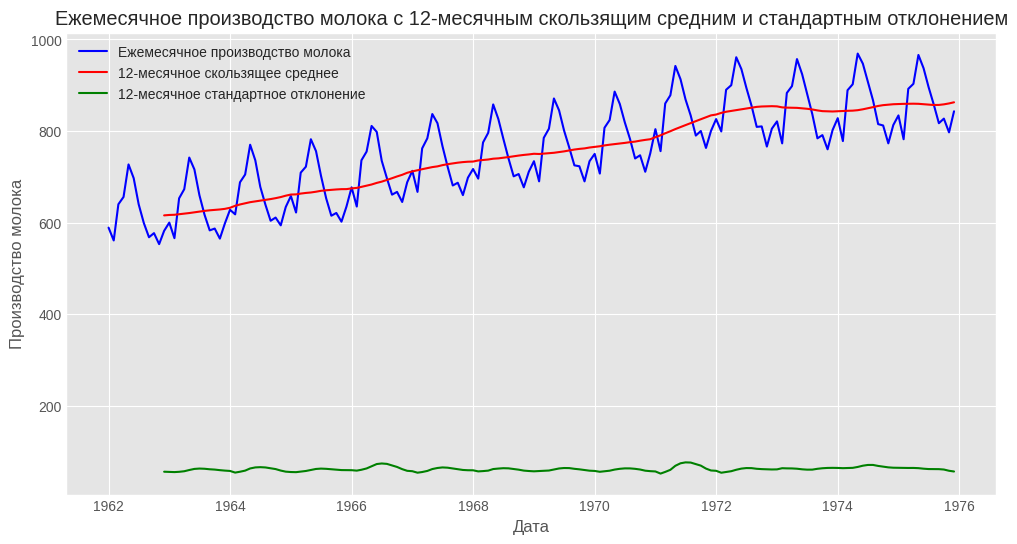

In [ ]:
milk_data['12-month-SMA'] = milk_data['Monthly milk production'].rolling(window=12).mean()
milk_data['12-month-Std'] = milk_data['Monthly milk production'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(milk_data['Monthly milk production'], label='Ежемесячное производство молока', color='blue')
plt.plot(milk_data['12-month-SMA'], label='12-месячное скользящее среднее', color='red')
plt.plot(milk_data['12-month-Std'], label='12-месячное стандартное отклонение', color='green')

plt.title('Ежемесячное производство молока с 12-месячным скользящим средним и стандартным отклонением')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.legend(loc='best')
plt.grid(True)

plt.show()


Средняя декомпозиция

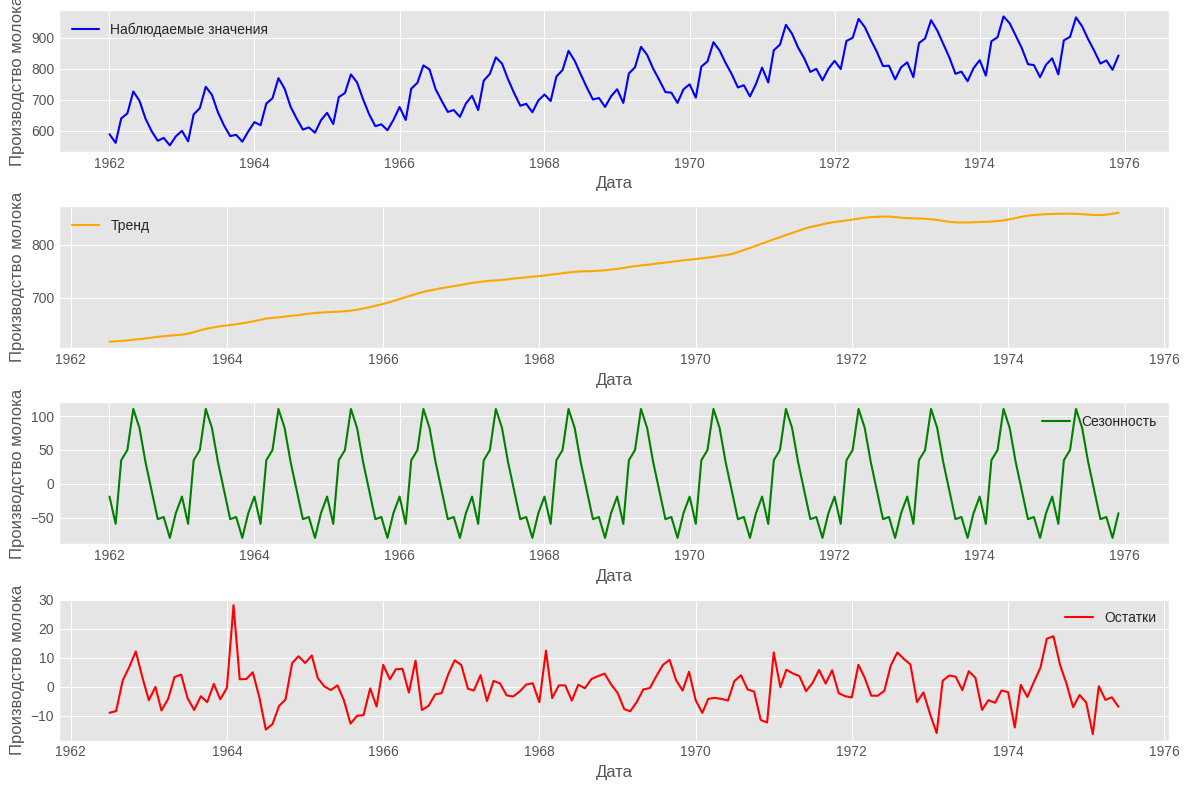

In [ ]:
ssn = seasonal_decompose(milk_data["Monthly milk production"], model="add")

# Построение графиков
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(ssn.observed, label='Наблюдаемые значения', color='blue')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.subplot(412)
plt.plot(ssn.trend, label='Тренд', color='orange')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.subplot(413)
plt.plot(ssn.seasonal, label='Сезонность', color='green')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.subplot(414)
plt.plot(ssn.resid, label='Остатки', color='red')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.tight_layout()
plt.show()

Автокорреляция

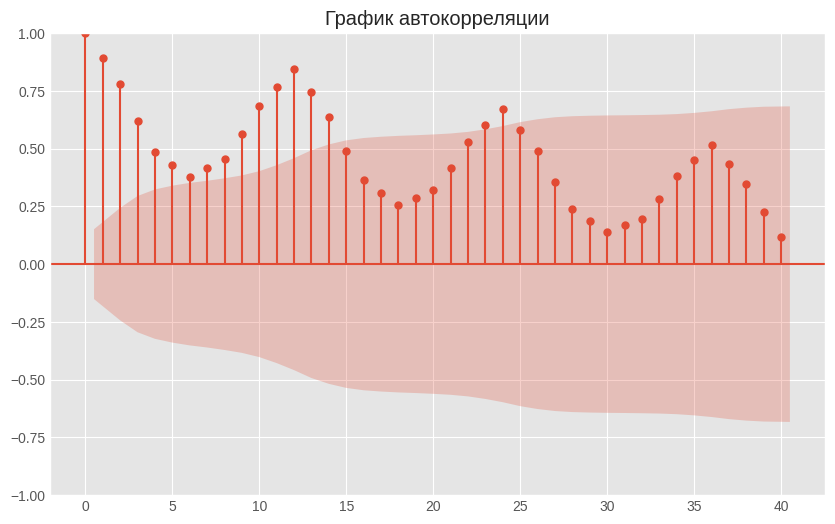

In [ ]:
plt.style.use('ggplot')
plot_acf(milk_data["Monthly milk production"], title='График автокорреляции', lags=40)
plt.show()


Проверка стационарности

In [ ]:
adf_test(milk_data["Monthly milk production"])

ADF тест                       -1.303812
p-value                         0.627427
# lags used                    13.000000
# наблюдения                  154.000000
критическое значение (1%)      -3.473543
критическое значение (5%)      -2.880498
критическое значение (10%)     -2.576878
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


Приведение ряда к стационарному

<ipython-input-157-94d8f1a76fba>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


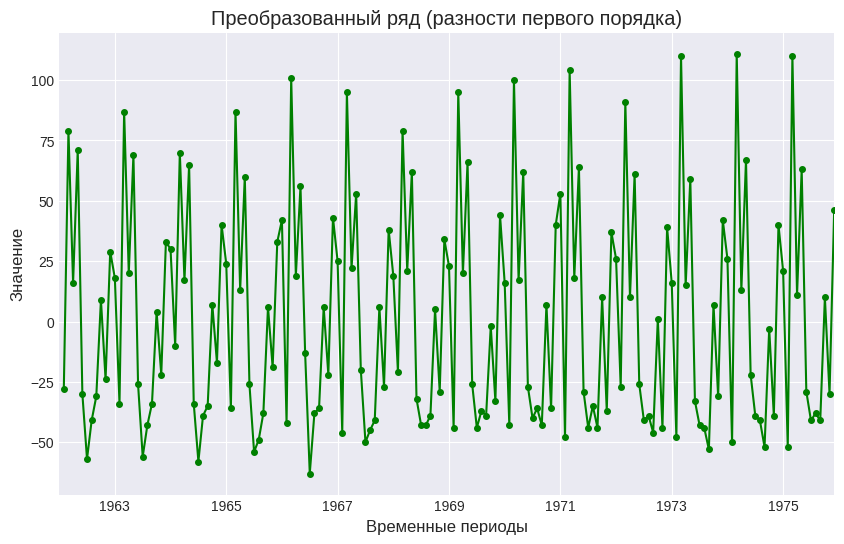

In [ ]:
milk_data["difference_1"] = diff(milk_data["Monthly milk production"], k_diff=1)
plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(10, 6))
milk_data["difference_1"].plot(ax=ax, color='green', linestyle='-', marker='o', markersize=4)

ax.set_title('Преобразованный ряд (разности первого порядка)')
ax.set_xlabel('Временные периоды')
ax.set_ylabel('Значение')

ax.grid(True)
plt.show()


 Проверка стационарнос

In [ ]:
adf_test(milk_data["difference_1"])

ADF тест                       -3.054996
p-value                         0.030068
# lags used                    14.000000
# наблюдения                  152.000000
критическое значение (1%)      -3.474121
критическое значение (5%)      -2.880750
критическое значение (10%)     -2.577013
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


Cтационарность после сезонной разности

<ipython-input-159-7b96f8b2a117>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


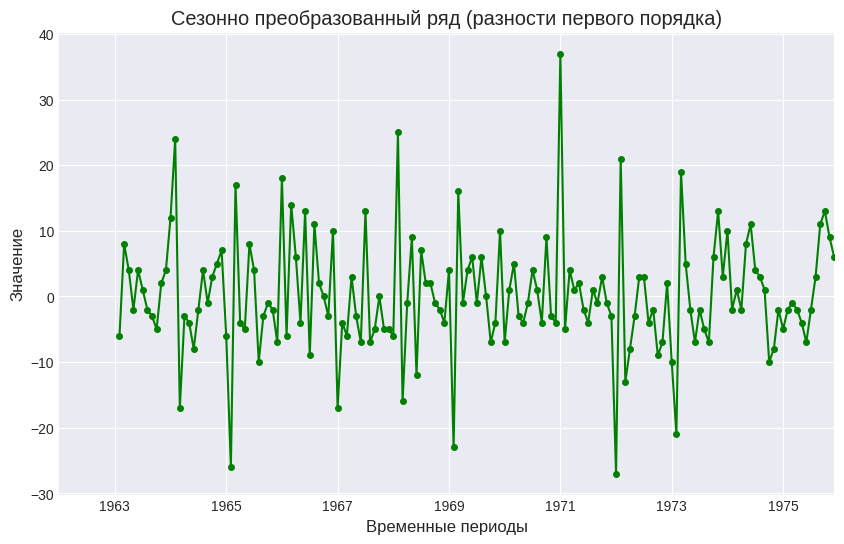

In [ ]:
milk_data["difference_seasonal"] = diff(milk_data["Monthly milk production"], k_diff=1, k_seasonal_diff=1, seasonal_periods=12)

plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(10, 6))
milk_data["difference_seasonal"].plot(ax=ax, color='green', linestyle='-', marker='o', markersize=4)

ax.set_title('Сезонно преобразованный ряд (разности первого порядка)')
ax.set_xlabel('Временные периоды')
ax.set_ylabel('Значение')

ax.grid(True)

plt.show()

 Проверка стационарнос

In [ ]:
adf_test(milk_data["difference_seasonal"])

ADF тест                       -5.038002
p-value                         0.000019
# lags used                    11.000000
# наблюдения                  143.000000
критическое значение (1%)      -3.476927
критическое значение (5%)      -2.881973
критическое значение (10%)     -2.577665
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


##Поиск параметров и обучение

Разделение на тестовый и тренировочный набор данных

In [ ]:
train= milk_data.iloc[:len(milk_data)-12]
test= milk_data.iloc[len(milk_data)-12:]

In [ ]:
smodel = auto_arima(train["Monthly milk production"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1203.992, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1218.095, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1015.855, Time=1.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1104.312, Time=1.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1349.320, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1039.187, Time=0.30 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1006.896, Time=3.84 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1001.453, Time=4.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1001.195, Time=1.47 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=999.197, Time=0.97 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1001.194, Time=3.10 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=10.01 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=994.889, Time=1.42 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1035.695, Time=0.43 sec
 ARIMA(2,0,0)(1,1,1)[12] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -490.431
Date:                            Mon, 24 Jun 2024   AIC                            994.862
Time:                                    09:22:27   BIC                           1015.650
Sample:                                01-01-1962   HQIC                          1003.309
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3091      2.038      1.623      0.105      -0.686       7.304
ar.L1         -0.2335      0.096     -2.430      0.015      -0.422      -0.045
ar.L2          0.8181      0.077     10.611      0.000       0.667       0.969
ar.L3          0.2510      0.096      2.619      0.009       0.063       0.439
ma.L1          0.9588      0.071     13.599      0.000       0.821       1.097
ma.S.L12      -0.6026      0.087     -6.947      0.000      -0.773      -0.433
sigma2        50.4394      5.268      9.575      0.000      40.115      60.764
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                50.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.84
Prob(H) (two-sided):                  0.34   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

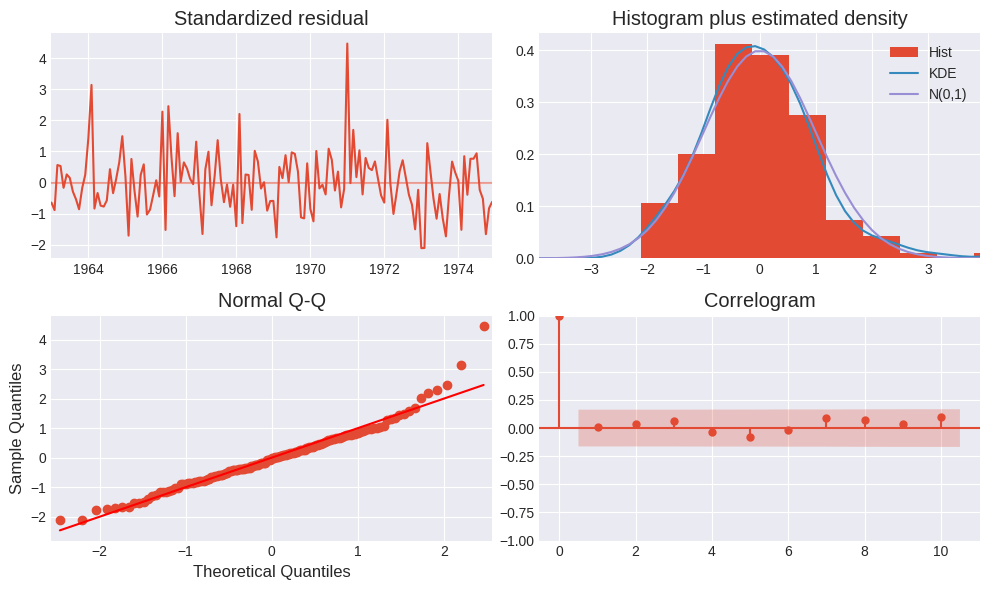

In [ ]:
smodel.plot_diagnostics()
plt.tight_layout()
plt.show()

Обучение

In [ ]:
sarima_model= SARIMAX(train["Monthly milk production"], order= (3,0,1), seasonal_order= (0,1,1,12))
sarima_model_fit= sarima_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Прогноз

In [ ]:
start= len(train)
end= len(train) + len(test) - 1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


График

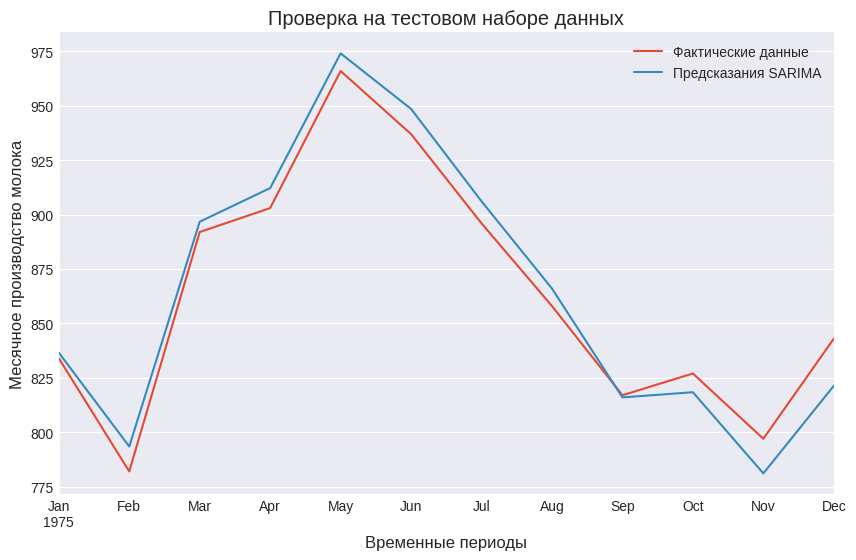

In [ ]:
test["Monthly milk production"].plot(title='Проверка на тестовом наборе данных', legend=True)

pred.plot(legend=True)
plt.legend(['Фактические данные', 'Предсказания SARIMA'])
plt.title('Проверка на тестовом наборе данных')

plt.xlabel('Временные периоды')
plt.ylabel('Месячное производство молока')

plt.show()

Оценка работы модели

In [ ]:
mse = mean_squared_error(test["Monthly milk production"], pred)
rmse_sarima = np.sqrt(mse)

print(f"Среднеквадратичная ошибка (MSE) = {mse:.2f}")
print(f"Корень из среднеквадратичной ошибки (RMSE) = {rmse_sarima:.2f}")

Среднеквадратичная ошибка (MSE) = 117.43
Корень из среднеквадратичной ошибки (RMSE) = 10.84


#Количесво пассажиров

##Предобработка данных

In [ ]:
#Загрузка данных
ps_data = pd.read_csv("AirPassengers.csv", delimiter=",", index_col="Month", parse_dates= True)
#первые 5 строк
ps_data.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
ps_data.rename(columns={"#Passengers":'Passengers'}, inplace=True)

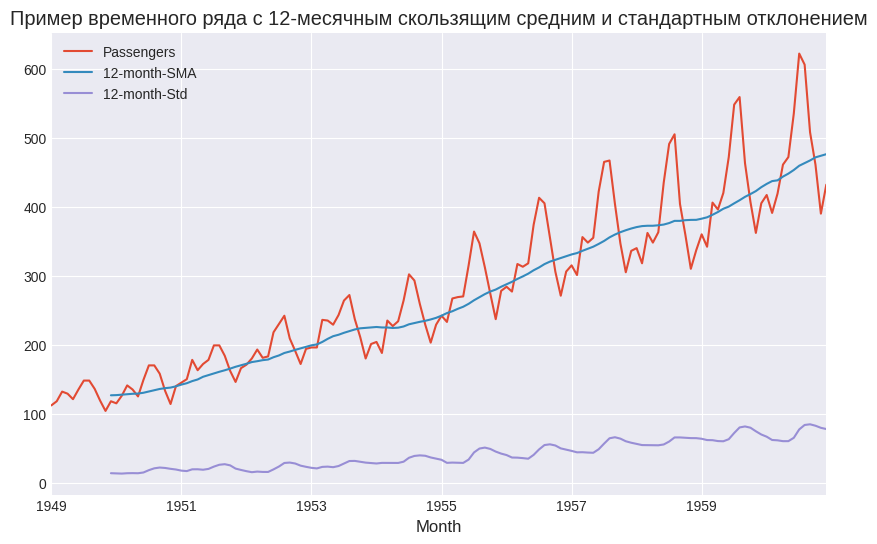

In [ ]:
ps_data['12-month-SMA'] = ps_data['Passengers'].rolling(window=12).mean()
ps_data['12-month-Std'] = ps_data['Passengers'].rolling(window=12).std()
ps_data[['Passengers', '12-month-SMA', '12-month-Std']].plot()
plt.title('Пример временного ряда с 12-месячным скользящим средним и стандартным отклонением')

plt.show()

Сезонная декомпозиция

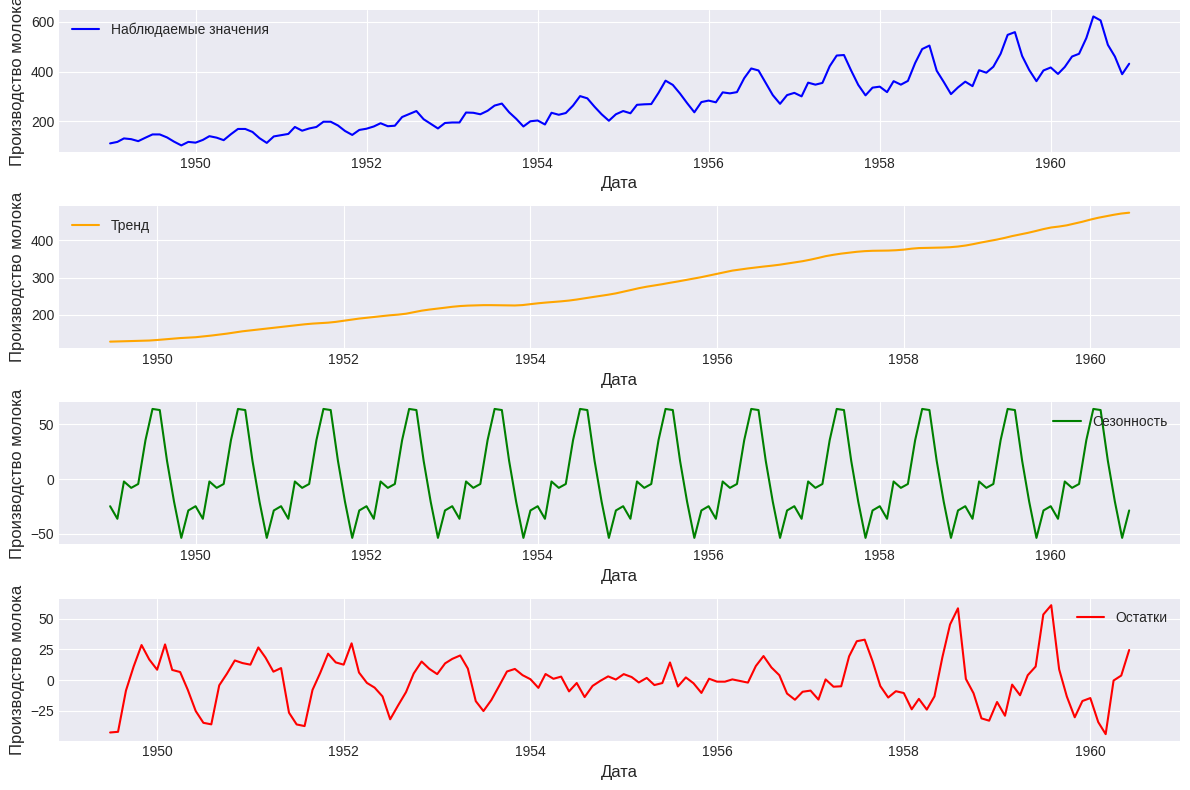

In [ ]:
ssn = seasonal_decompose(ps_data["Passengers"], model="add")
# Построение графиков
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(ssn.observed, label='Наблюдаемые значения', color='blue')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.subplot(412)
plt.plot(ssn.trend, label='Тренд', color='orange')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.subplot(413)
plt.plot(ssn.seasonal, label='Сезонность', color='green')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.subplot(414)
plt.plot(ssn.resid, label='Остатки', color='red')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.tight_layout()
plt.show()

Автокорреляция

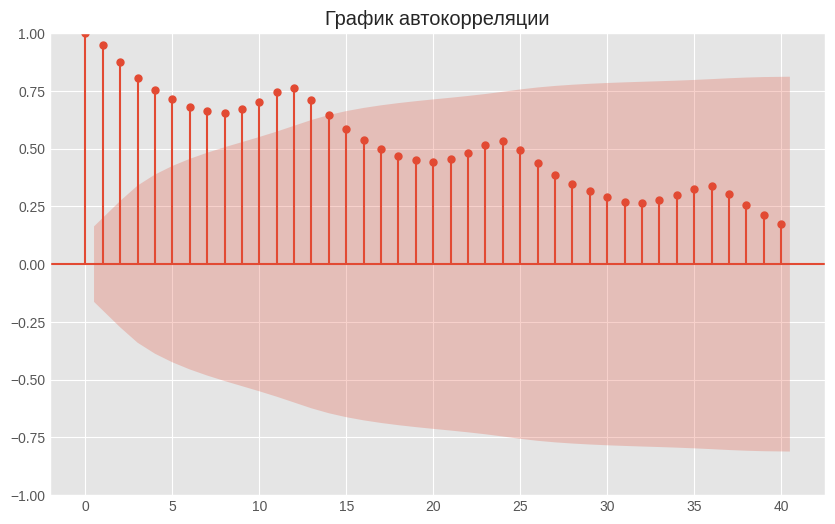

In [ ]:
plt.style.use('ggplot')
plot_acf(ps_data["Passengers"], title='График автокорреляции', lags=40)
plt.show()

Проверка стационарности

In [ ]:
adf_test(ps_data["Passengers"])

ADF тест                        0.815369
p-value                         0.991880
# lags used                    13.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


Приведение ряда к стационарному

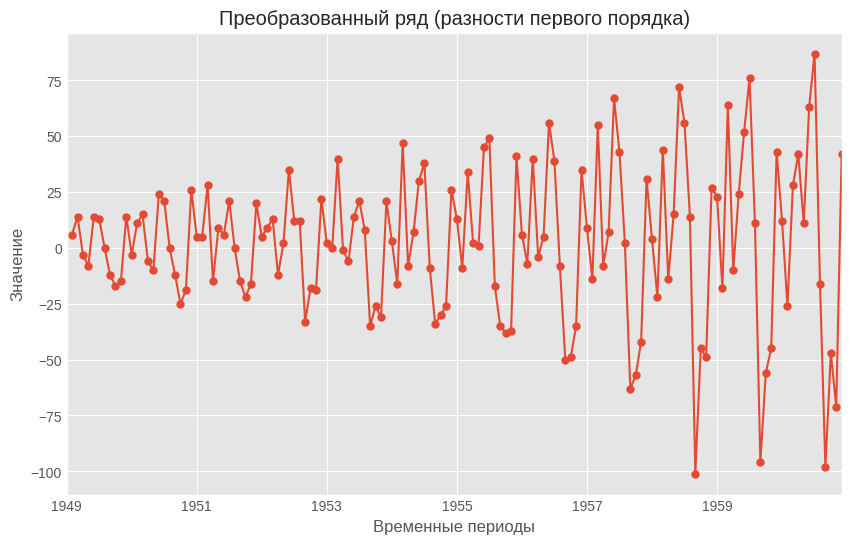

In [ ]:
ps_data["difference_1"] = diff(ps_data["Passengers"], k_diff=1)

fig, ax = plt.subplots(figsize=(10, 6))

ps_data["difference_1"].plot(ax=ax, marker='o', markersize=5, linestyle='-')

ax.set_title('Преобразованный ряд (разности первого порядка)')
ax.set_xlabel('Временные периоды')
ax.set_ylabel('Значение')

ax.grid(True)

plt.show()


Проверка стационарности

In [ ]:
adf_test(ps_data["difference_1"])

ADF тест                       -2.829267
p-value                         0.054213
# lags used                    12.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


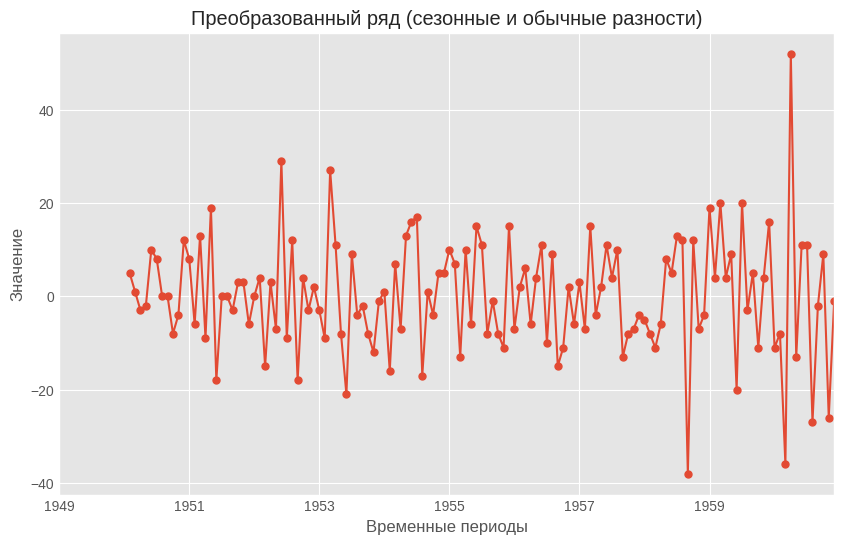

In [ ]:
# Применяем сезонное и обычное дифференцирование
ps_data["difference_seasonal"] = diff(ps_data["Passengers"], k_diff=1, k_seasonal_diff=1, seasonal_periods=12)

# Создаем график
fig, ax = plt.subplots(figsize=(10, 6))

# Строим график разностей сезонного ряда с маркерами точек на вершинах
ps_data["difference_seasonal"].plot(ax=ax, marker='o', markersize=5, linestyle='-')

# Настройка графика
ax.set_title('Преобразованный ряд (сезонные и обычные разности)')
ax.set_xlabel('Временные периоды')
ax.set_ylabel('Значение')

# Включаем сетку на графике
ax.grid(True)

# Отображаем график
plt.show()


In [ ]:
adf_test(ps_data["difference_seasonal"])

ADF тест                     -1.559562e+01
p-value                       1.856512e-28
# lags used                   0.000000e+00
# наблюдения                  1.300000e+02
критическое значение (1%)    -3.481682e+00
критическое значение (5%)    -2.884042e+00
критическое значение (10%)   -2.578770e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


### Поиск параметров и обучение

Разделение на тестовый и тренировочный набор данных

In [ ]:
train= ps_data.iloc[:len(ps_data)-12]
test= ps_data.iloc[len(ps_data)-12:]

In [ ]:
smodel = auto_arima(train["Passengers"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.34 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.45 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.70 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=1.19 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.18 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.47 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Mon, 24 Jun 2024   AIC                            905.686
Time:                                    09:22:51   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

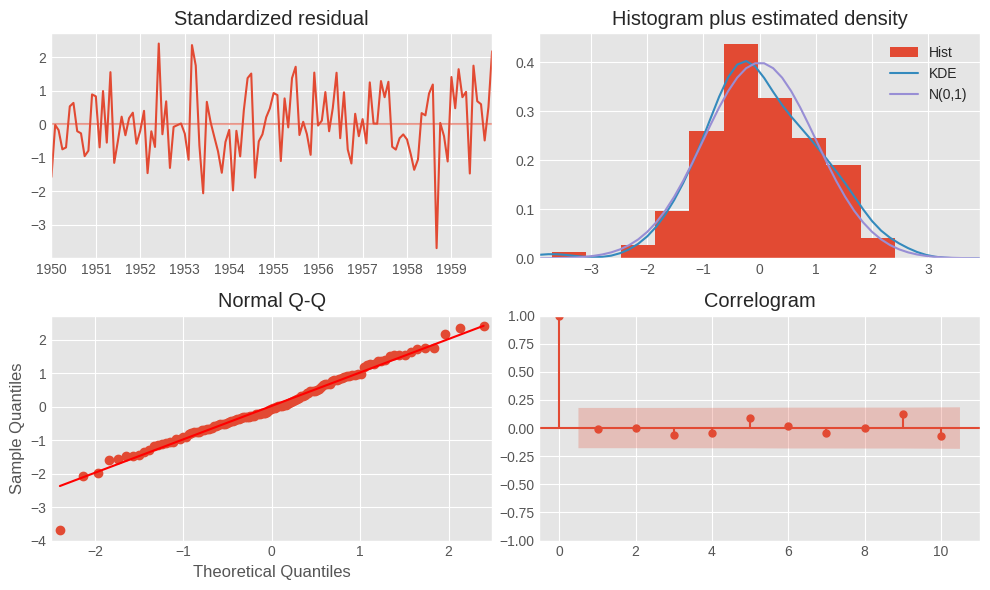

In [ ]:
smodel.plot_diagnostics()
plt.tight_layout()

Обучение

In [ ]:
sarima_model= SARIMAX(train["Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12))
sarima_model_fit= sarima_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Прогноз

In [ ]:
start= len(train)
end= len(train) + len(test) - 1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Построение графика

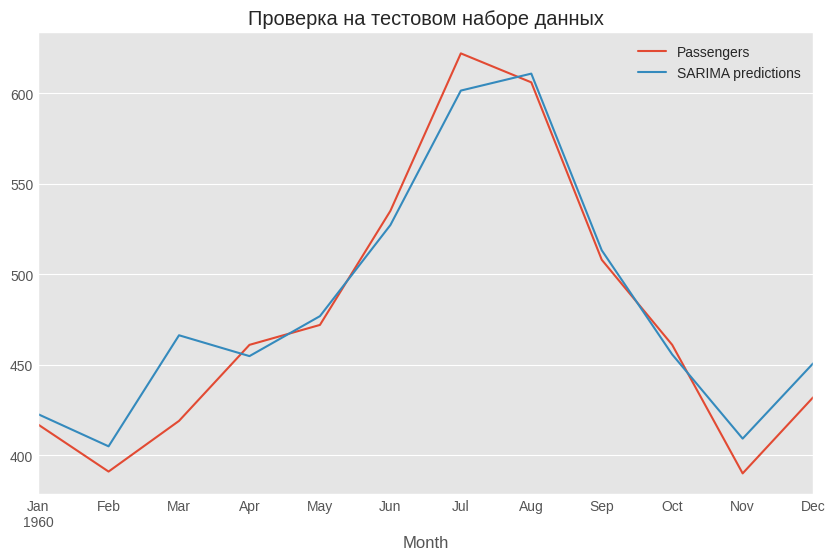

In [ ]:
test["Passengers"].plot(title= 'Проверка на тестовом наборе данных', legend=True)
fog = pred.plot(legend=True)

Оценка модели

In [ ]:
mse= mean_squared_error(test["Passengers"],pred)
rmse_sarima= rmse(test["Passengers"], pred)

print(f"Среднеквадратичная ошибка (MSE) = {mse:.2f}")
print(f"Корень из среднеквадратичной ошибки (RMSE) = {rmse_sarima:.2f}")

Среднеквадратичная ошибка (MSE) = 317.40
Корень из среднеквадратичной ошибки (RMSE) = 17.82


##Количество сотрудников

## Предобработка и визуализация набора данных

In [ ]:
#Загрузка данных
emp_df = pd.read_csv("aus_employment.csv",  delimiter = ',', index_col="date", parse_dates= True)
#первые 5 строк
emp_df.head(5)

,people_employed
date,
1978-01-01,5985.7
1978-02-01,6040.6
1978-03-01,6054.2
1978-04-01,6038.3
1978-05-01,6031.3


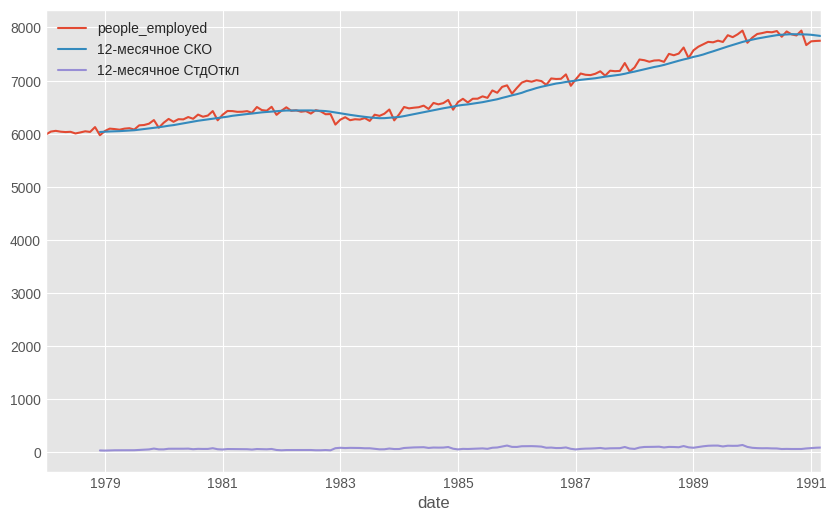

In [ ]:
emp_df['12-месячное СКО'] = emp_df['people_employed'].rolling(window=12).mean()
emp_df['12-месячное СтдОткл'] = emp_df['people_employed'].rolling(window=12).std()

emp_df[['people_employed', '12-месячное СКО', '12-месячное СтдОткл']].plot();

plt.show()

Сезонная декомпозиция

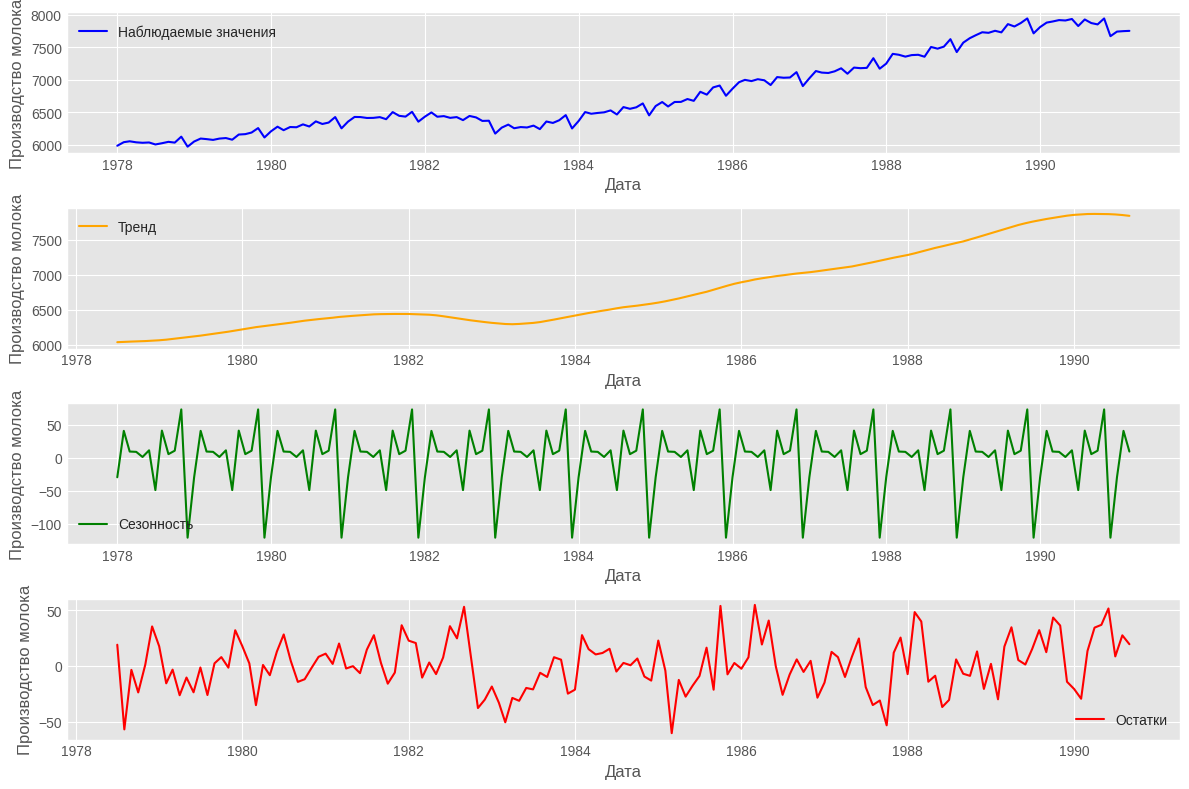

In [ ]:
ssn = seasonal_decompose(emp_df["people_employed"], model="add")

# Построение графиков
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(ssn.observed, label='Наблюдаемые значения', color='blue')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.subplot(412)
plt.plot(ssn.trend, label='Тренд', color='orange')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.subplot(413)
plt.plot(ssn.seasonal, label='Сезонность', color='green')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.subplot(414)
plt.plot(ssn.resid, label='Остатки', color='red')
plt.legend(loc='best')
plt.xlabel('Дата')
plt.ylabel('Производство молока')

plt.tight_layout()
plt.show()

Автокорреляция

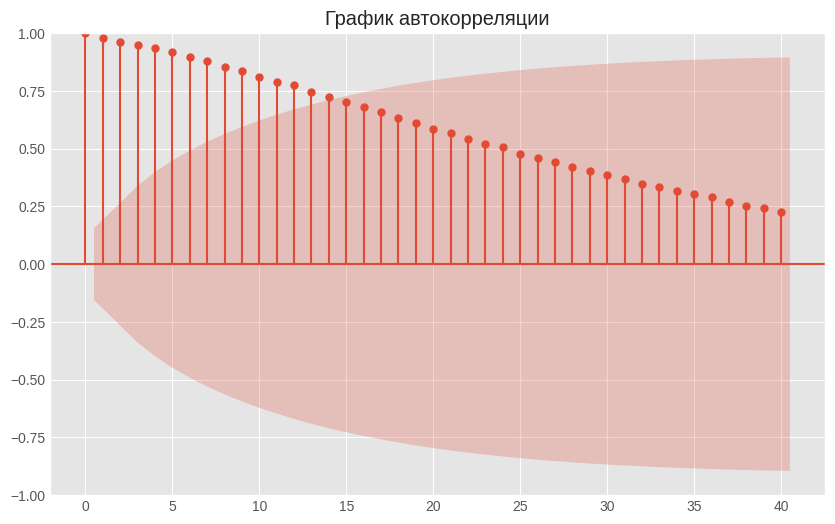

In [ ]:
plot_acf(emp_df["people_employed"], title='График автокорреляции', lags=40)
plt.show()

Проверка стационарности

In [ ]:
adf_test(emp_df["people_employed"])

ADF тест                       -1.400145
p-value                         0.582207
# lags used                    13.000000
# наблюдения                  145.000000
критическое значение (1%)      -3.476273
критическое значение (5%)      -2.881688
критическое значение (10%)     -2.577513
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


Приведение ряда к стационарному

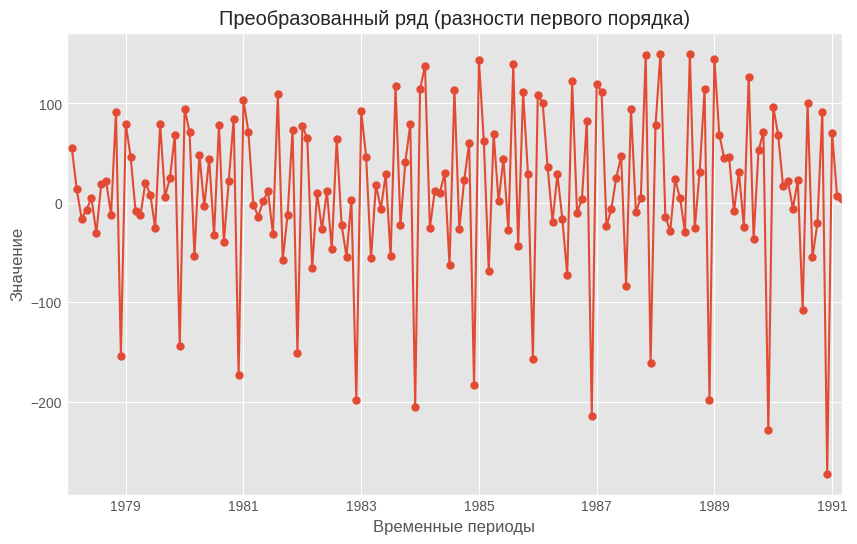

In [ ]:
emp_df["difference_1"] = diff(emp_df["people_employed"], k_diff=1)

fig, ax = plt.subplots(figsize=(10, 6))

emp_df["difference_1"].plot(ax=ax, marker='o', markersize=5, linestyle='-')

ax.set_title('Преобразованный ряд (разности первого порядка)')
ax.set_xlabel('Временные периоды')
ax.set_ylabel('Значение')

ax.grid(True)

plt.show()

### Поиск параметров и обучение

In [ ]:
train= emp_df.iloc[:len(emp_df)-12]
test= emp_df.iloc[len(emp_df)-12:]

Разделение на тестовый и тренировочный набор данных

In [ ]:
smodel = auto_arima(train["people_employed"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1615.725, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1698.275, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1494.908, Time=0.73 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1589.529, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1700.112, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1667.292, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1456.152, Time=1.01 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1593.738, Time=0.42 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1458.067, Time=2.23 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1550.728, Time=1.16 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1459.762, Time=1.36 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  147
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -723.334
Date:                              Mon, 24 Jun 2024   AIC                           1454.669
Time:                                      09:23:30   BIC                           1466.603
Sample:                                  01-01-1978   HQIC                          1459.518
                                       - 03-01-1990                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1905      0.081     -2.358      0.018      -0.349      -0.032
ar.S.L12       0.9916      0.008    130.327      0.000       0.977       1.006
ma.S.L12      -0.7088      0.094     -7.508      0.000      -0.894      -0.524
sigma2       974.4366    106.830      9.121      0.000     765.053    1183.820
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.92   Prob(JB):                         0.24
Heteroskedasticity (H):               2.02   Skew:                             0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

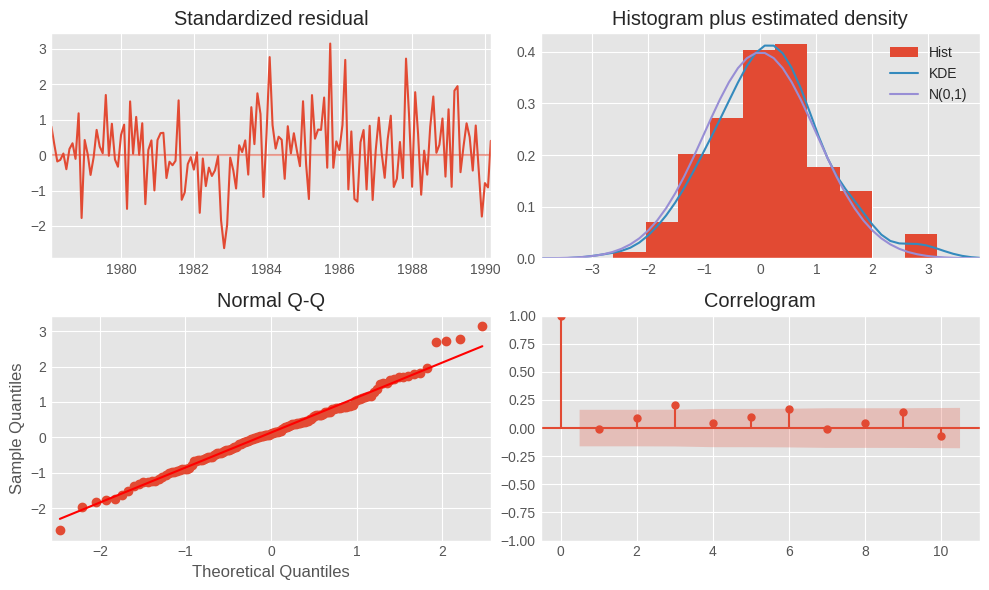

In [ ]:
smodel.plot_diagnostics()
plt.tight_layout()

Обучение

In [ ]:
sarima_model= SARIMAX(train["people_employed"], order= (1,1,0), seasonal_order= (1,0,1,12))
sarima_model_fit= sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Прогноз

In [ ]:
start= len(train)
end= len(train) + len(test) - 1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Построение графика

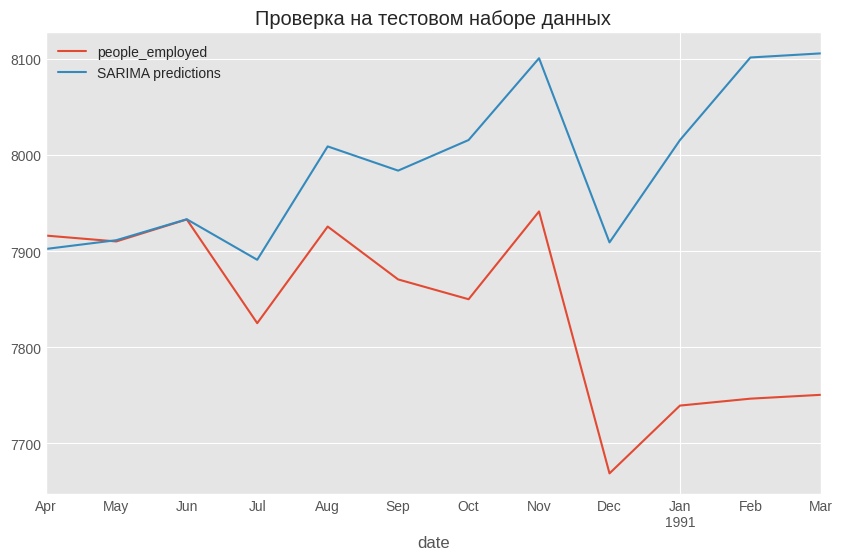

In [ ]:
test["people_employed"].plot(title= 'Проверка на тестовом наборе данных', legend=True)
fog = pred.plot(legend=True)

Оценка работы модели

In [ ]:
mse= mean_squared_error(test["people_employed"],pred)
rmse_sarima= rmse(test["people_employed"], pred)

print(f"Среднеквадратичная ошибка (MSE) = {mse:.2f}")
print(f"Корень из среднеквадратичной ошибки (RMSE) = {rmse_sarima:.2f}")

Среднеквадратичная ошибка (MSE) = 38579.39
Корень из среднеквадратичной ошибки (RMSE) = 196.42
